# Pytransformsorch session 2 - testing GPU

## Outline
1. Introduction to `torch.nn`, `torch.nn.Module`
2. Building a simple network using `torch.linear`
3. Basic use of `torch.optim`
3. Building a simple CNN


In this session we will walk through the steps for creating artificial neural networks and Convolutional Neural Networks (ANNs and CNNs) using tools built-in to PyTorch. This largely follows [PyTorch's ``nn.Module`` tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) as well as this [pytorch mnist tutorial on kaggle](https://nextjournal.com/gkoehler/pytorch-mnist). 

The dataset we use is the **MNIST** hand-written digits dataset. This consists of black-and-white images of hand-drawn digits between 0 and 9. It is often referred to as the "hello world" of machine learning. 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torchvision
from torch import nn
import os
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import Compose, ToTensor
from PIL import Image
from torchvision import transforms



# Dataset

# test - convert originaol to noise

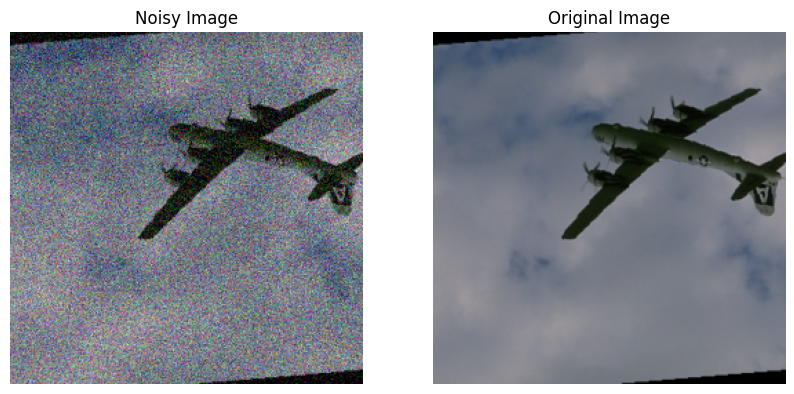

In [5]:
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms 
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

class AdjustedDenoisingDataset(Dataset):
    def __init__(self, root_dir, noise_std, transform=None, training=True):
        self.root_dir = root_dir
        self.transform = transform
        self.training = training
        self.noise_std = noise_std  # Now we pass the noise_std when initializing the dataset
        self.image_ids = [f"{i:04d}.png" for i in (range(56) if training else range(56, 68))]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        original_img_path = os.path.join(self.root_dir, 'original_png', image_id)  # Adjusted to use self.root_dir
        original_image = Image.open(original_img_path).convert("RGB")
        
        if self.transform:
            original_image = self.transform(original_image)
        
        original_image_np = np.array(original_image)
        standard_deviation = random.uniform(0, self.noise_std)

        noise = np.random.normal(0, standard_deviation, original_image_np.shape).astype(np.float32)
        noisy_image_np = original_image_np + noise
        noisy_image_np = np.clip(noisy_image_np, 0, 255).astype(np.uint8)
        
        noisy_image = Image.fromarray(noisy_image_np)
        
        noisy_image_tensor = transforms.ToTensor()(noisy_image)
        original_image_tensor = transforms.ToTensor()(original_image)
        
        return noisy_image_tensor, original_image_tensor

# Define transformations

transformations = transforms.Compose([
    transforms.RandomRotation((0, 360)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop((256, 256), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.Resize((256, 256))
])

# Example of how to instantiate the dataset for a specific noise level (e.g., 5)
noise_std = 50  # Standard deviation of the Gaussian noise
# Assuming adjusted_dataset is an instance of AdjustedDenoisingDataset with the transform applied
training_dataset = AdjustedDenoisingDataset(root_dir='CBSD68-dataset/CBSD68', noise_std=noise_std, transform=transformations, training=True)
test_dataset = AdjustedDenoisingDataset(root_dir='CBSD68-dataset/CBSD68', noise_std=noise_std, transform=transformations, training=False)

import matplotlib.pyplot as plt

# Assuming dataset is the instance of AdjustedDenoisingDataset
noisy_image, original_image = training_dataset[0]

# Convert the tensors to PIL images
noisy_image_pil = transforms.ToPILImage()(noisy_image)
original_image_pil = transforms.ToPILImage()(original_image)

# Display the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(noisy_image_pil)
axes[0].set_title('Noisy Image')
axes[0].axis('off')
axes[1].imshow(original_image_pil)
axes[1].set_title('Original Image')
axes[1].axis('off')

plt.show()



# Print the shapes of the noisy and original images
# print(f"Noisy image shape: {noisy_image.shape}")
# print(f"Original image shape: {original_image.shape}")

# MODEL

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the U-Net model
model = UNet(n_channels=3, n_classes=3).to(device)  # Adjust n_channels and n_classes if necessary

# TRAIN MODEL

training

In [67]:
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms

batch_size = 8
n_epochs = 10
lr = 0.001

# Assuming AdjustedDenoisingDataset is correctly implemented and instantiated as 'dataset'
data_loader = DataLoader(training_dataset, batch_size, shuffle=True)

# Assuming the U-Net model is instantiated as 'model'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define an optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr)
criterion = nn.MSELoss()

def train_model(model, data_loader, optimizer, criterion, n_epochs):
    losses = []
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        for batch in data_loader:
            noisy_imgs, original_imgs = batch
            noisy_imgs, original_imgs = Variable(noisy_imgs.to(device)), Variable(original_imgs.to(device))
            
            optimizer.zero_grad()
            
            outputs = model(noisy_imgs)
            loss = criterion(outputs, original_imgs)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            losses.append(loss.item())
        
        epoch_loss = running_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss}")
    print('Finished Training')
    return losses

# Train the model
losses = train_model(model, data_loader, optimizer, criterion, n_epochs)


Epoch 1/10, Loss: 0.034205863385328224
Epoch 2/10, Loss: 0.016639238090387413
Epoch 3/10, Loss: 0.01075738821444767
Epoch 4/10, Loss: 0.010558264263506447
Epoch 5/10, Loss: 0.008821307947593076
Epoch 6/10, Loss: 0.007546408168439355
Epoch 7/10, Loss: 0.006842209225786584
Epoch 8/10, Loss: 0.006203714225973401
Epoch 9/10, Loss: 0.007090891578367778
Epoch 10/10, Loss: 0.005623408127576113
Finished Training


# save model

In [11]:
import os
# Specify the directory to save the file
save_dir = 'models'

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Specify the filename
filename = 'trained_model'
filename = filename + str(len(os.listdir(save_dir))) + '.pth'

# Save the model state dictionary
torch.save(model.state_dict(), os.path.join(save_dir, filename))


## Load Model

In [22]:
# Load model
import os

# List all the files in the '2_saved_models' folder
saved_models_folder = 'models'
matches = []
for root, dirnames, filenames in os.walk(saved_models_folder):
    for filename in filter(lambda name: name.endswith('.pth'), filenames):
        matches.append(os.path.join(root, filename))

# Display the available model files
print("Available model files:")
for i, file in enumerate(matches):
    print(f"{i+1}. {file}")

# Prompt the user to enter the index of the model file they want to load
selected_index = int(input("Enter the index of the model file to load: ")) - 1

# Load the selected model file
selected_model_file = matches[selected_index]
model = UNet(n_channels=3, n_classes=3)
model.load_state_dict(torch.load(selected_model_file))

Available model files:
1. models/trained_model11.pth
2. models/trained_model2.pth
3. models/old_trained_models/trained_model11.pth
4. models/old_trained_models/trained_model13.pth
5. models/old_trained_models/trained_model12.pth
6. models/old_trained_models/trained_model15.pth
7. models/old_trained_models/trained_model14.pth


<All keys matched successfully>

# plot

In [13]:
import matplotlib.pyplot as plt
plt.plot(losses)   

NameError: name 'losses' is not defined

## test data 
#### (compare loss function values)

In [23]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()  # Set the model to evaluation mode
criterion = nn.MSELoss()


test_losses = []
with torch.no_grad():
    for batch in test_loader:
        noisy_img, original_img = batch
        noisy_img, original_img = noisy_img.to(device), original_img.to(device)
        
        output = model(noisy_img)
        loss = criterion(output, original_img)
        test_losses.append(loss.item())

average_loss = sum(test_losses) / len(test_losses)
print(f"Average loss on test dataset: {average_loss}")


Average loss on test dataset: 0.03488866239786148


## test image against model

Loss value (MSE): 0.04293261840939522


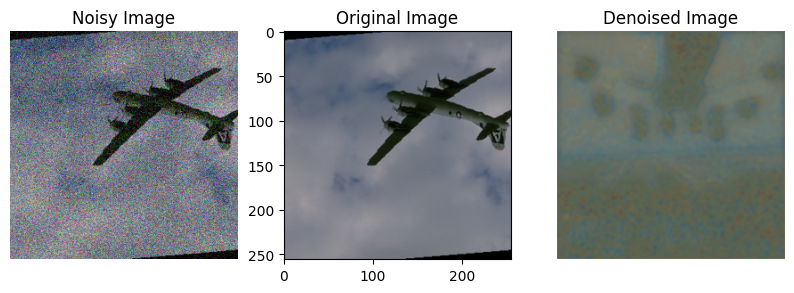

In [18]:
import requests
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from io import BytesIO
import matplotlib.pyplot as plt

# Additional function to convert tensor to PIL Image for visualization
def tensor_to_pil(tensor):
    unloader = transforms.ToPILImage()  # Convert tensor to PIL Image
    image = tensor.cpu().clone()  # Clone the tensor to not do changes on it
    image = image.squeeze(0)      # Remove the fake batch dimension
    image = unloader(image)
    return image

# Function to fetch image
def fetch_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.convert('RGB') 
    return img

# Function to apply Gaussian noise
def apply_gaussian_noise(image, noise_level):
    image = np.array(image)
    noise = np.random.normal(0, noise_level, image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_image)

def add_awgn_to_image(pil_img, noise_std=25):
    """
    Adds Additive White Gaussian Noise (AWGN) to a PIL image.

    Parameters:
        pil_img (PIL.Image): The input PIL image to which AWGN will be added.
        noise_std (float): The standard deviation of the Gaussian noise. Default is 25.

    Returns:
        PIL.Image: The PIL image with AWGN added.
    """

    # Convert PIL image to NumPy array
    img_array = np.array(pil_img)

    # Generate AWGN noise
    noise = np.random.normal(0, noise_std, img_array.shape)
    noise = noise.reshape(img_array.shape).astype('uint8')

    # Add noise to the image
    noisy_img_array = img_array + noise
    noisy_img_array = np.clip(noisy_img_array, 0, 255)  # Ensure values stay within [0, 255]

    # Convert NumPy array back to PIL image
    noisy_pil_img = Image.fromarray(noisy_img_array.astype('uint8'))

    return noisy_pil_img

# Function to denoise image using model
def denoise_image(image):
    model.eval()

    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        # Add any other preprocessing (e.g., normalization)
    ])

    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(input_tensor)
    return output.squeeze(0)  # Remove batch dimension


def process_image(image_url, noise_level):
    original_image = fetch_image(image_url)
    original_image = original_image.resize((256, 256))
    noisy_image = add_awgn_to_image(original_image, noise_level)
    
    # Convert original_image to tensor for loss computation
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    original_image_tensor = preprocess(original_image)

    denoised_image_tensor = denoise_image(noisy_image)
    denoised_image = tensor_to_pil(denoised_image_tensor)

    # Compute loss
    loss = F.mse_loss(denoised_image_tensor, original_image_tensor)
    print(f"Loss value (MSE): {loss.item()}")

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Change the number of subplots from 2 to 3
    axes[0].imshow(noisy_image_pil)
    axes[0].set_title('Noisy Image')
    axes[0].axis('off')
    axes[1].imshow(original_image_pil)
    axes[1].set_title('Original Image')
    axes[2].imshow(denoised_image)
    axes[2].set_title('Denoised Image')
    axes[2].axis('off')
    plt.show()

plt.show()
    

image_url = input("Enter the URL of the image to denoise: \n")
noise_level = float(input("Enter the noise level (0-100): \n"))
process_image(image_url, noise_level)